In [7]:
# Import 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, widgets

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [8]:
#Load the data
"""
tracking_files = ['/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv',
                    '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv',
                  '/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv']
"""
tracking_data_week_1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv')
tracking_data = tracking_data_week_1

"""
try:
    tracking_data = pd.concat([pd.read_csv(file) for file in tracking_files])
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
"""

games_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')
players_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
plays_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
tackles_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')


In [9]:
# Merge data 

# Merge relevant columns from tracking_data with tackles_data
merged_data = pd.merge(tackles_data, tracking_data[['gameId', 'playId', 'nflId', 'o','s', 'a', 'dis', 'x', 'y']], 
                       on=['gameId', 'playId', 'nflId'], how='inner')

# Objective 

Explore, visualize, and analyze various aspects of player tracking and tackling data, from player behavior to network structure and predictive modeling.

# 1. Player Tracking Data Visualization
                                                
**Objective**: Creates an interactive tool for exploring player tracking data for a specific week.

**Key Features:**
* Utilizes the ipywidgets library to provide an interactive interface.
* Allows users to select specific players for personalized exploration.
* Generates scatter plots of player orientation and angle of motion, filtered by specific events.
* Facilitates interactive data exploration for coaches, analysts, and other stakeholders.



In [10]:
"""
Player Tracking Data Visualization - To visualize player tracking data in a sports context. The primary focus is on two key aspects: 
player orientation and the angle of player motion. The script is designed for interactive exploration, allowing users to select specific
players and observe their movement patterns.
"""
# Get unique player names
player_names = tracking_data['displayName'].unique()

# Select relevant columns
orientation_column = 'o'
motion_angle_column = 'dir'
event_column = 'event'

# Define a function to create scatter plots based on player selection
def plot_player(selected_player_name):
    selected_player_data = tracking_data[tracking_data['displayName'] == selected_player_name]

    # Create a scatter plot for player orientation and angle of motion
    plt.figure(figsize=(12, 6))
    plt.scatter(selected_player_data[orientation_column], selected_player_data[motion_angle_column],
                c=selected_player_data['frameId'], cmap='viridis', label='Events', alpha=0.7)
    plt.title(f'{selected_player_name} - Player Orientation vs. Angle of Player Motion')
    plt.xlabel('Player Orientation (degrees)')
    plt.ylabel('Angle of Player Motion (degrees)')
    plt.colorbar(label='Frame ID')
    plt.legend()
    plt.show()

    # Filter data for specific events (e.g., 'tackle' and 'pass_release')
    selected_events = ['tackle', 'pass_release']
    filtered_data = tracking_data[tracking_data[event_column].isin(selected_events)]

    # Create a scatter plot for player orientation and angle of motion (filtered by events)
    plt.figure(figsize=(12, 6))
    for event in selected_events:
        event_data = filtered_data[filtered_data[event_column] == event]
        plt.scatter(event_data[orientation_column], event_data[motion_angle_column], label=event, alpha=0.5)

    plt.scatter(selected_player_data[orientation_column], selected_player_data[motion_angle_column],
                color='red', marker='X', label='Selected Player')
    plt.title(f'{selected_player_name} - Player Orientation vs. Angle of Player Motion (Filtered by Events)')
    plt.xlabel('Player Orientation (degrees)')
    plt.ylabel('Angle of Player Motion (degrees)')
    plt.legend()
    plt.show()

# Create an interactive dropdown menu
interact(plot_player, selected_player_name=widgets.Dropdown(options=player_names, description='Select Player'));


interactive(children=(Dropdown(description='Select Player', options=('Rodger Saffold', 'Bobby Wagner', 'Aaron …

# 2. Tackling Network Centrality
 
**Objective:** Visualizes the tackling network in a football game using tracking and tackle data.

**Key Features:**
* Creates a directed graph representing player interactions during tackles.
* Normalizes edge weights and removes isolated nodes for clarity.
* Utilizes network analysis to identify the largest weakly connected component.
* Visualizes the tackling network using a circular layout for better interpretation.  

Number of weakly connected components: 41


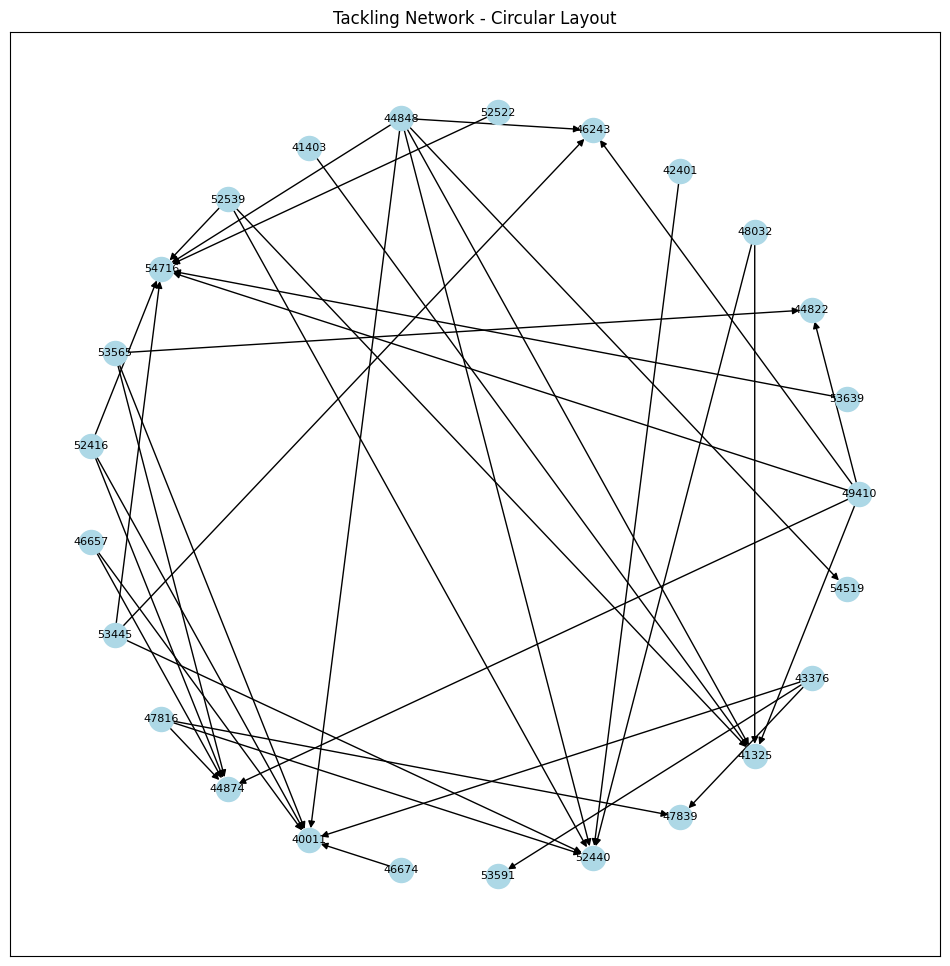

In [11]:
"""
Tackling Network Centrality: Applying network analysis to identify key players
in the defensive network whose tackles significantly impact the overall defensive effectiveness.
"""
try:
    
    # Fill null values with a default value (e.g., zero)
    tracking_data_week_1= tracking_data_week_1.fillna(0)
    tackles_data = tackles_data.fillna(0)
    games_data = games_data.fillna(0)
    plays_data = plays_data.fillna(0)

    # Check for null values after filling
    #if tracking_data.isnull().values.any() or tackles_data.isnull().values.any() or games_data.isnull().values.any() or plays_data.isnull().values.any():
    #    print("Warning: Null values are still present after attempting to handle them.")

    # Merge tracking data with tackle data
    merged_data = pd.merge(tackles_data, tracking_data_week_1, on=['gameId', 'playId', 'nflId'], how='inner')

    # Check if the merged dataframe is empty
    if merged_data.empty:
        raise ValueError("Merged dataframe is empty. Check data loading and merging steps.")

    # Merge plays and tackles data on gameId and playId
    merged_df = pd.merge(plays_data, merged_data, on=['gameId', 'playId'])

    # Create a directed graph to represent the tackling network
    tackling_graph = nx.DiGraph()

    # Add nodes for each player
    tackling_graph.add_nodes_from(merged_df['nflId'], label='Player')

    # Add edges based on tackles
    for _, row in merged_df.iterrows():
        if row['tackle'] == 1:
            tackling_graph.add_edge(row['nflId'], row['ballCarrierId'], weight=1)

    # Normalize edge weights
    max_weight = max(tackling_graph.edges(data=True), key=lambda x: x[2]['weight'], default=(None, None, {'weight': 1}))[2]['weight']
    for edge in tackling_graph.edges(data=True):
        edge[2]['weight'] /= max_weight

    # Remove isolated nodes
    tackling_graph.remove_nodes_from(list(nx.isolates(tackling_graph)))

    # Check weak connectivity
    if not nx.is_weakly_connected(tackling_graph):
        print("Warning: The tackling graph is not weakly connected.")

    # Weakly connected components
    weakly_connected_components = list(nx.weakly_connected_components(tackling_graph))
    print(f"Number of weakly connected components: {len(weakly_connected_components)}")

    # Subgraph of the largest weakly connected component
    largest_component = max(weakly_connected_components, key=len)
    tackling_graph = tackling_graph.subgraph(largest_component).copy()

    # Plot the tackling network with Circular layout
    plt.figure(figsize=(12, 12))
    pos_circular = nx.circular_layout(tackling_graph)
    nx.draw_networkx(tackling_graph, pos_circular, with_labels=True, node_size=300, font_size=8, node_color='lightblue')
    plt.title("Tackling Network - Circular Layout")
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("An error occurred.")

# 3. Credit Assignment Analysis
                                            
**Objective:** Assigns credit to players involved in successful tackles based on specific 
criteria.

**Key Features:**
* Utilizes XGBoost classifier to assign credit for successful tackles.
* Creates a cumulative credit assignment for players based on involvement in successful tackles.
* Trains a regression model to predict tackle time based on assigned credit.
* Visualizes credit assignment predictions in scatter plots for analysis.
 

Accuracy for Tackle Credit Assignment: 1.0


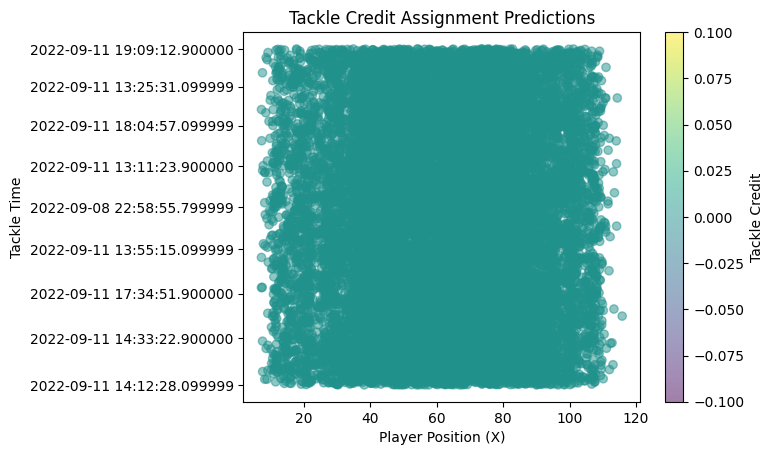

In [12]:
""" 
Credit Assignment Analysis: Explore credit assignment for tackles, considering factors like one player making a 
tackle because of area of influence. This can help understand the collaborative nature of tackling.
"""

# Merge tracking data with tackle data
tackles_df = pd.merge(tackles_data, tracking_data, on=['gameId', 'playId', 'nflId'], how='inner')

# Merge plays and tackles data on gameId and playId
merged_df = pd.merge(plays_data, tackles_df, on=['gameId', 'playId'])

# Feature engineering
features = ['x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event']

# Encode categorical features
label_encoder = LabelEncoder()
merged_df['event'] = label_encoder.fit_transform(merged_df['event'])

# Impute missing values for numerical features with the mean
numerical_features = ['x', 'y', 's', 'a', 'dis', 'o', 'dir']
imputer = SimpleImputer(strategy='mean')
merged_df[numerical_features] = imputer.fit_transform(merged_df[numerical_features])

# Create a binary target variable indicating whether a tackle was successful
merged_df['successful_tackle'] = (merged_df['event'] == 'Tackle') & (merged_df['dis'] < 1.5)

# Define the area of influence (you may need to customize this based on your criteria)
area_of_influence = 5.0  # For example, players within 5 yards of the tackle

# Identify players involved in a successful tackle based on the area of influence
merged_df['involved_in_tackle'] = np.where(
    (merged_df['successful_tackle']) &
    (np.abs(merged_df['x'] - merged_df['x'].shift(-1)) < area_of_influence),
    1,
    0
)

# Credit assignment: Assign credit to players involved in successful tackles
merged_df['tackle_credit'] = merged_df.groupby(['gameId', 'playId', 'nflId'])['involved_in_tackle'].cumsum()

# Regression target: tackle time
y_time = merged_df['time']

# Split the data into training and testing sets
X_train, X_test, y_time_train, y_time_test = train_test_split(
    merged_df[features], y_time, test_size=0.2, random_state=42
)

# Train XGBoost regression model for tackle time
xgboost_time_model = XGBClassifier()
xgboost_time_model.fit(X_train, merged_df['tackle_credit'].iloc[X_train.index])

# Make predictions
tackle_credit_pred = xgboost_time_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(merged_df['tackle_credit'].iloc[X_test.index], tackle_credit_pred)
print(f'Accuracy for Tackle Credit Assignment: {accuracy}')

# Visualize credit assignment predictions
plt.yticks([])
plt.scatter(X_test['x'], y_time_test, c=tackle_credit_pred, cmap='viridis', alpha=0.5)
plt.yticks(y_time_test[::len(y_time_test)//8])  # Set your desired label positions here
plt.xlabel('Player Position (X)')
plt.ylabel('Tackle Time')
plt.title('Tackle Credit Assignment Predictions')
plt.colorbar(label='Tackle Credit')
plt.show()

# 4. Player Profile Analysis
                                            
**Objective:** Explores the relationship between player attributes (e.g., height, weight, position) and tackling performance.

**Key Features:**
* Merges tracking, tackles, and player data to create a comprehensive dataset.
* Conducts data preprocessing, handling missing values and converting height to a standardized format.
* Visualizes the relationship between player attributes (height, weight) and tackling performance, broken down by player position.


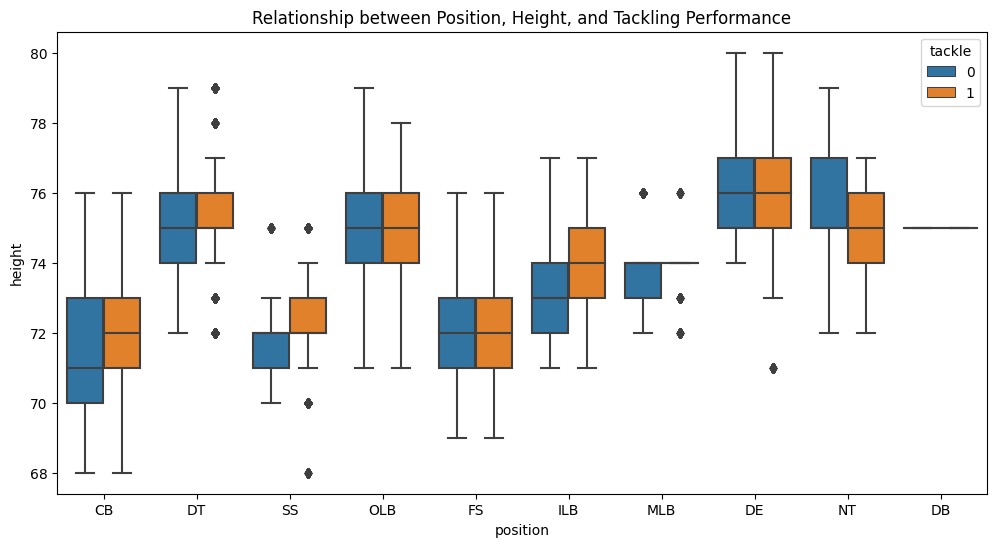

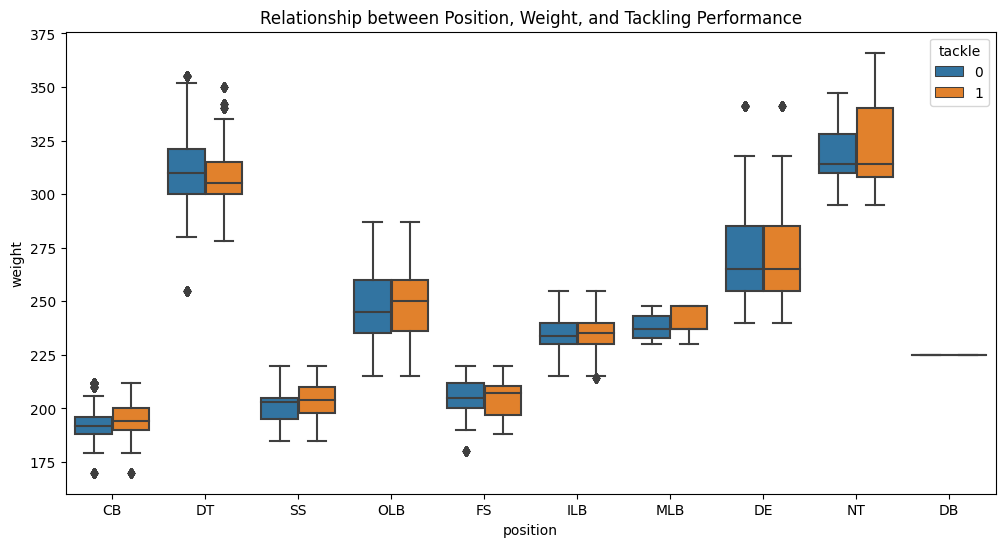

In [13]:
"""
Player Profile Analysis: Explore the relationship between player attributes (e.g., height, weight, position) 
and their tackling performance.
"""

# Merge tracking and tackles data
merged_data = pd.merge(tackles_data, tracking_data, on=['gameId', 'playId', 'nflId'], how='inner')

# Merge merged_data with players data
player_profile_data = pd.merge(merged_data, players_data, on='nflId', how='inner')

# Consider relevant columns for player profile analysis
profile_analysis_data = player_profile_data[['height', 'weight', 'position', 'tackle']]

profile_analysis_data = profile_analysis_data.copy()

# Handle missing value
profile_analysis_data.dropna(subset=['height'], inplace=True)

# Convert Height to Inches
def convert_height_to_inches(height_str):
    if '-' in height_str:
        feet, inches = map(int, height_str.split('-'))
        return feet * 12 + inches
    else:
        return int(height_str)

profile_analysis_data['height'] = profile_analysis_data['height'].apply(convert_height_to_inches)

# Use .loc to set values
profile_analysis_data.loc[:, 'height'] = pd.to_numeric(profile_analysis_data['height'], errors='coerce')

# Plotting the relationship between height and tackling performance
plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='height', data=profile_analysis_data, hue='tackle')
plt.title('Relationship between Position, Height, and Tackling Performance')
plt.show()

# Plotting the relationship between weight and tackling performance
plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='weight', data=profile_analysis_data, hue='tackle')
plt.title('Relationship between Position, Weight, and Tackling Performance')
plt.show()


# 5. Tackle Location Prediction

**Objective:** Predicts the likely location of a tackle based on player's position, direction, and speed.

**Key Features:**
* Merges tackle and tracking data, selecting relevant features for prediction.
* Utilizes linear regression models to predict x and y coordinates of tackle locations.
* Evaluates model performance using Mean Squared Error.
* Provides a 3D visualization of predicted tackle locations for spatial analysis.

Mean Squared Error for x-coordinate: 0.00
Mean Squared Error for y-coordinate: 0.00


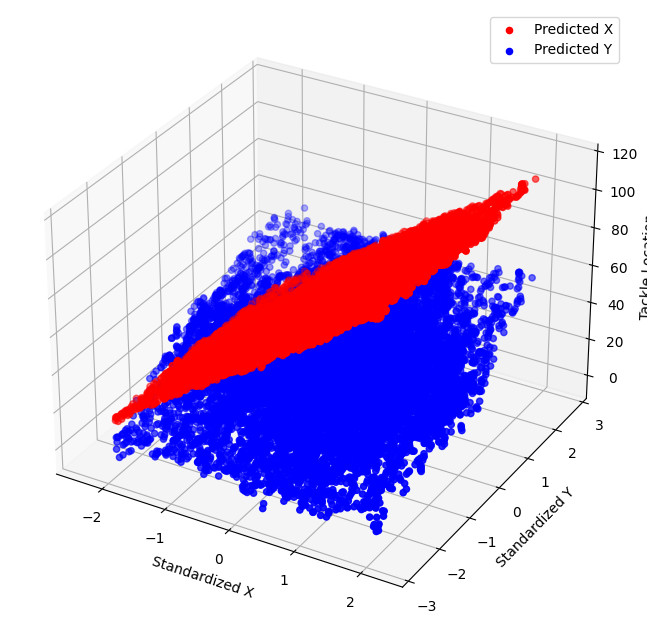

In [14]:
"""
Tackle Location Prediction: Spatial analysis to predict the likely location of a tackle. 
Consider the player's position, direction, and speed to estimate where a tackle is most likely to occur.
"""

# Define features and target variables
features = ['x', 'y', 'o', 's']
target_x = 'x'
target_y = 'y'

# Select features and target variables
X = merged_data[features]
y_x = merged_data[target_x]
y_y = merged_data[target_y]


# Split the data into training and testing sets
X_train, X_test, y_x_train, y_x_test, y_y_train, y_y_test = train_test_split(
    X, y_x, y_y, test_size=0.2, random_state=42
)

# Handle missing values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train the linear regression model for x-coordinate
model_x = LinearRegression()
model_x.fit(X_train_scaled, y_x_train)

# Train the linear regression model for y-coordinate
model_y = LinearRegression()
model_y.fit(X_train_scaled, y_y_train)

# Make predictions on the test set
y_x_pred = model_x.predict(X_test_scaled)
y_y_pred = model_y.predict(X_test_scaled)

# Evaluate the linear regression models
mse_x = mean_squared_error(y_x_test, y_x_pred)
mse_y = mean_squared_error(y_y_test, y_y_pred)

# Print metrics
print(f'Mean Squared Error for x-coordinate: {mse_x:.2f}')
print(f'Mean Squared Error for y-coordinate: {mse_y:.2f}')

# Visualize predicted tackles in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_x_pred, c='r', marker='o', label='Predicted X')
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_y_pred, c='b', marker='o', label='Predicted Y')
ax.set_xlabel('Standardized X')
ax.set_ylabel('Standardized Y')
ax.set_zlabel('Tackle Location')
ax.legend()
plt.show()


# 6. Tackle Range Analysis

**Objective:** Analyzes the angle of pursuit, speed, acceleration, and closing speed of players involved in tackles.

**Key Features:**
* Calculates the angle of pursuit based on player orientation and direction.
* Visualizes the relationship between angle of pursuit and closing speed.
* Analyzes the relationship between speed and acceleration during tackles.
* Provides insights into effective tackling strategies and player performance.

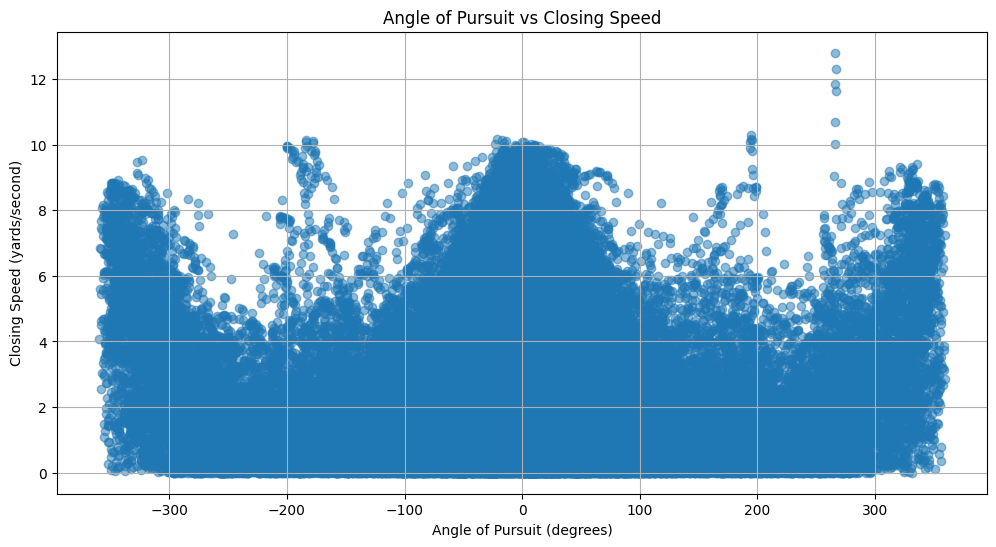

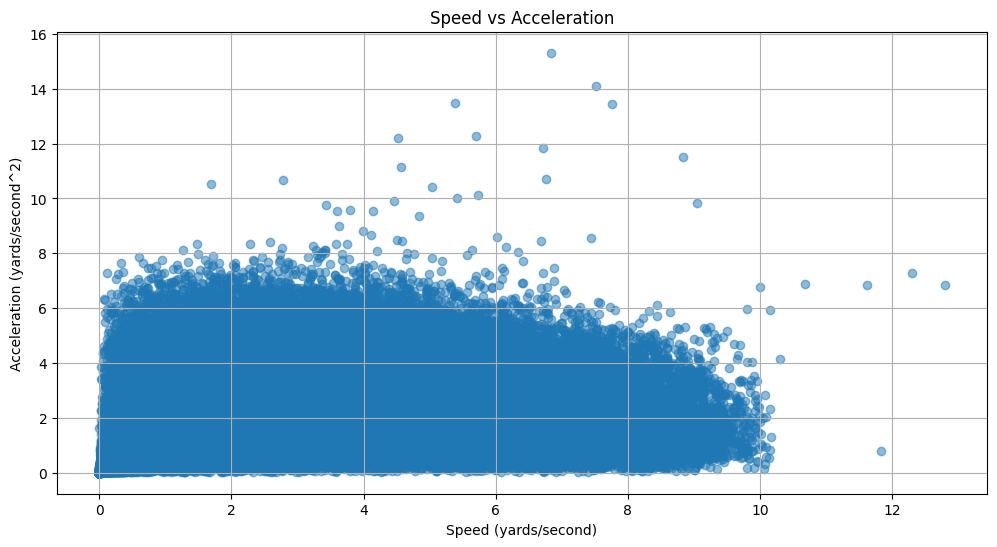

In [15]:
"""
Tackle Range Analysis: Analyze the angle of pursuit, speed, acceleration and closing speed of players
involved in tackles. This can provide insights into effective tackling strategies and player performance.
"""

# Merge tracking data with tackle data
merged_data = pd.merge(tackles_data, tracking_data, on=['gameId', 'playId', 'nflId'], how='inner')

# Calculate angle of pursuit
merged_data['angle_of_pursuit'] = merged_data['dir'] - merged_data['o']

# Extract relevant features
features = ['angle_of_pursuit', 's', 'a', 'dis']
target = 's'  # Assuming you have a column representing closing speed

# Select features and target variables
X = merged_data[features]
y = merged_data[target]

# Plotting angle of pursuit vs closing speed
plt.figure(figsize=(12, 6))
plt.scatter(merged_data['angle_of_pursuit'], merged_data['s'], alpha=0.5)
plt.title('Angle of Pursuit vs Closing Speed')
plt.xlabel('Angle of Pursuit (degrees)')
plt.ylabel('Closing Speed (yards/second)')
plt.grid(True)
plt.show()

# Plotting speed vs acceleration
plt.figure(figsize=(12, 6))
plt.scatter(merged_data['s'], merged_data['a'], alpha=0.5)
plt.title('Speed vs Acceleration')
plt.xlabel('Speed (yards/second)')
plt.ylabel('Acceleration (yards/second^2)')
plt.grid(True)
plt.show()


# Conclusion

Facilitates strategic insights, player profiling, credit assignment, and spatial predictions, optimizing performance and informing decision-making in football.

# Appendix

import pandas as pd

week1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv')
week1.info()
week1.head()


games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')
games.info()
games.head()


players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
players.info()
players.head()


plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
plays.info()
plays.head()

tackles = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')
tackles.info()
tackles.head()
